### Import necessary packages

In [2]:
import numpy as np
import pandas as pd
import sklearn
import lightgbm as lgb
import shap
import xgboost
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


### California Housing Dataset 

In [7]:
cal_data = fetch_california_housing()

In [8]:
print(cal_data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [10]:
X = cal_data.data
y = cal_data.target 
cal_features = cal_data.feature_names

cal_df = pd.concat((pd.DataFrame(X, columns = cal_features ),
                    pd.DataFrame({'MedianHouseVal': y})), axis=1)

In [11]:
cal_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [12]:
# Split dataset into training and testing data. 20% for testing, 80% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [13]:
# Train an XGBoost model
xgb_regressor = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators =500)
xgb_regressor.fit(X_train, y_train) # fit to training data

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [14]:
# Mean Squared Error
def compute_mse(predictions, true_labels):
    return np.mean((predictions - true_labels)**2)

In [15]:
test_predictions = np.squeeze(xgb_regressor.predict(X_test)) # use np.squeeze() to remove all dimensions of size 1 from the NumPy array
mse_test = compute_mse(test_predictions, y_test)
print(f'the Root Mean Squared Error of this XGBoost model is {np.sqrt(mse_test)}')

the Root Mean Squared Error of this XGBoost model is 0.4525658506907664


### Time to Explain using SHAP

In [31]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


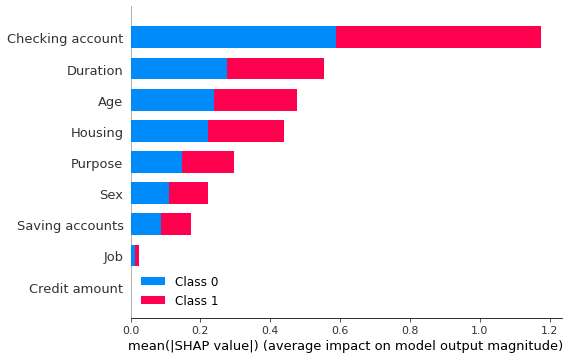

In [32]:
shap.summary_plot(shap_values, x_test)

In [33]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], features.iloc[0,:]) # how model arrived at a decision based on a specific observation (person in the case of this dataset)


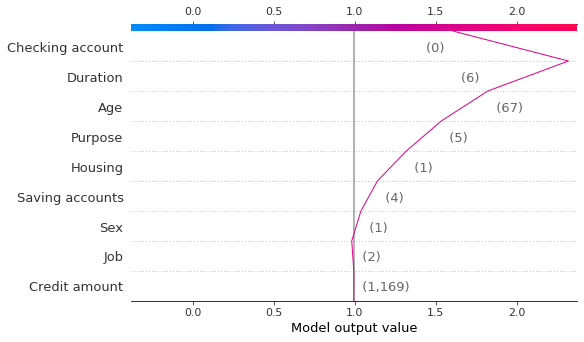

In [35]:
# both force plots and decision plots depict feature importance in a model’s output. Decision plots 
shap.decision_plot(explainer.expected_value[1], shap_values[1][0,:], features.iloc[0,:])

Feature Dependence plot for: Purpose


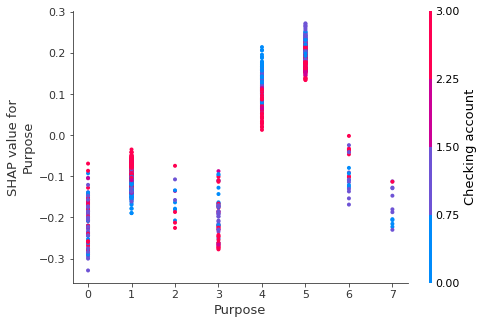

Feature Dependence plot for: Age


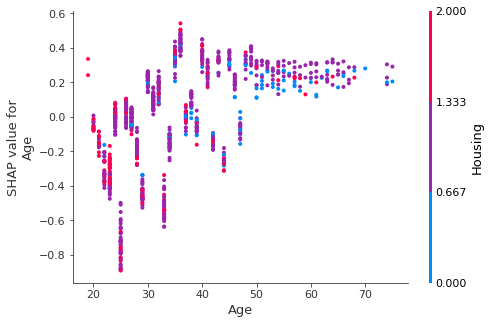

In [36]:
for column in ['Purpose', 'Age']:
    print(f"Feature Dependence plot for: {column}")

    shap.dependence_plot(column, shap_values[1], features, display_features=features)